Testing *distilled* version of BERT model for text classification.

In [ ]:
!pip install transformers
!pip install pycld2

In [71]:
import pandas as pd
import numpy as np
import pycld2 as cld2
import tensorflow as tf
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import json
import gc
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
document_risk = pd.read_csv("./qa06_only_having_risk_valuesl.csv")
document_risk = document_risk.rename(columns={'qa06id': 'id', 'qa06name':'title', 'qa06wher':'location','qa06dsc':'report','ty26colo':'label','ty26fakt':'factor'})

document = pd.read_csv("./qa06_all.csv")
document = document.rename(columns={'qa06id': 'id', 'qa06name':'title', 'qa06wher':'location','qa06dsc':'report'})

acronyms = pd.read_excel("./kratice.xlsx")
acronyms = acronyms.rename(columns={'kratice':'acronym','Unnamed: 1':'replacement'})

The only text preparation that is needed before BERT is removing the NaN values and (optionally) modify the acronyms.

In [4]:
def isNaN(string):
    return string != string

def acronyms_to_words (txt): 
    for i in range (len(acronyms)):
        txt=txt.replace(' ' + acronyms.acronym[i] + ' ',' ' + acronyms.replacement[i] + ' ')
    return txt

def prep_doc(document,isRisk):
    
    if isRisk :
        doc = pd.DataFrame(columns=['xx', 'report', 'label','factor', 'accident'])
    else:
        doc = pd.DataFrame(columns=['xx', 'report'])
    
    for i in range(len(document)):
       
        if isNaN(document.report[i]):
            continue
            
  # checking the languange with few lines below
  # if English and isRelible then continue the process and if not continue with the next report and go through the loop again
        isReliable, textBytesFound, details=cld2.detect(document.report[i])
        if not isReliable:
            continue
        if details[0][0]!='ENGLISH':
            continue
            
        prepared_text = acronyms_to_words(document.report[i])
       
#     Here it is important to know a little bit more about aviation risk classification.
#     These reports, according to predetermined parameters, are classified in line with 
#     the risk factor given in the non-equidistant scale from 1 to 2500. 
#     Considering this factor, there are 3 classes of events: 
#         - No accident outcome -Minor injuries or damage - Major or catastrophic accident (including death)
#     We defined a feature "accident" that contain information about which of these 3 classes each report belong to.
#     This was the best way to have any proper and relevant data to classify.
 
#     For better understanding next few lines look the AvioClass.jpg
        if isRisk :
            if (document.factor[i]==1):
                risk_level='no accident outcome'
            elif (document.factor[i] in (2,4,20,100)):
                risk_level='minor injuries or damage'
            else:
                risk_level='major or catastrophic accident'
            
            doc=doc.append({'xx': document.xx[i], 'report': prepared_text, 
                    'label': document.label[i], 'factor': document.factor[i],
                        'accident': risk_level},ignore_index=True)
        
        else:
            doc=doc.append({'xx': document.xx[i], 'report': prepared_text}, ignore_index=True) 
    return doc

Preparing our data:

In [5]:
doc_for_BERT = prep_doc(document_risk, True)

In [6]:
doc_for_BERT.head()

,xx,report,label,factor,accident
0,2522377,CM2 was performing ILS RAW data approach on tr...,0,2,minor injuries or damage
1,2346650,Bru approach rw 25L ILS. Still on asighned hea...,0,2,minor injuries or damage
2,2047008,There were no security seals on board takeoff ...,0,1,no accident outcome
3,2528229,VIE RWY 34\r\nAt position RH base radar HDG 24...,1,20,minor injuries or damage
4,2139606,Electrical smell found by cabin crew member in...,0,1,no accident outcome


First, a little bit of organizing the *accident* feature

In [7]:
doc_for_BERT.accident.unique()

array(['minor injuries or damage', 'no accident outcome',
       'major or catastrophic accident'], dtype=object)

In [ ]:
# Categories (3 of them) will be assigned to a unique number 

doc_for_BERT['encoded_category'] = doc_for_BERT['accident'].astype('category').cat.codes
doc_for_BERT.encoded_category.unique()

Making a dictionary of categories

In [58]:
cat = doc_for_BERT.accident.unique()
unique_nmb = doc_for_BERT.encoded_category.unique()
categories_dict = dict(zip(unique_nmb,cat))
categories_dict

{0: 'major or catastrophic accident',
 1: 'minor injuries or damage',
 2: 'no accident outcome'}

Making a list of prepared data for future model

In [10]:
final_reports = doc_for_BERT["report"].to_list() # (only text) data prepared for model
final_category = doc_for_BERT["encoded_category"].to_list() # our new category labels for each report

Now, data is to be splitted into three parts, training set on the one side (in purpose to train the model) and validation and test sets on the other side (to help us calculate the performance of the model).



In [11]:
# Split Train and Validation data
train_text, val_text, train_cat, val_cat = train_test_split(final_reports, final_category, test_size=0.3, random_state=0)

# Keep some data for testing
val_text, test_text, val_cat, test_cat = train_test_split(val_text, val_cat, test_size=0.5, random_state=0)


Since we didn't tokenize the reports, it will be done by tokenizer from *HuggingFace's* transformers library that is compatible with *HuggingFace's* model we are going to use. <br> For this classification task that model is going to be *TFDistilBertForSequenceClassification* (*HuggingFace*). <br> Because of that, first we will use *DistilBertTokenizer* to tokenize our texts. <br> *TFDistilBertForSequenceClassification* will fine-tune the pre-trained model using the output from the tokenizer. <br>
Outputs of *DistilBertTokenizer* are **input_ids** and **attention_mask**. They are needed arguments in DistilBert model.

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_text, truncation=True, padding=True)
val_encodings = tokenizer(val_text, truncation=True, padding=True)
test_encodings = tokenizer(test_text, truncation=True, padding=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Before the fine-tuning, we need to convert our input encodings into a TensorFlow Dataset object.

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_cat
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_cat
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_cat
))

*from_pretrained()* method to initialize a pre-trained model.

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Next step is fitting the model on our dataset

In [15]:
NMB_EPOCHS=6

In [16]:
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=NMB_EPOCHS, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))

Epoch 1/6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

Let's check is 6 epochs maybe too much. With the same function loss and accuracy from train and validation data will be compared

In [34]:
def eval_metric(history, metric_name):

    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    line = range(1, NMB_EPOCHS + 1)
    plt.plot(line, metric, 'bo', label='Train ' + metric_name, color="green", markersize = 3)
    plt.plot(line, val_metric, 'b', label='Validation ' + metric_name,color="green", linewidth = 1)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for model')
    plt.legend()
    plt.show()

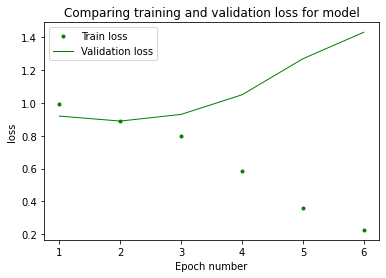

In [35]:
eval_metric(history, 'loss')

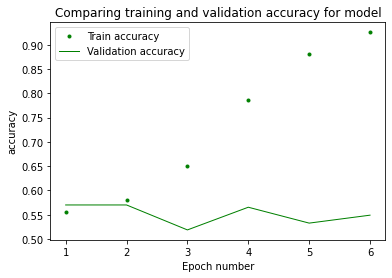

In [36]:
eval_metric(history, 'accuracy')

The graph seen above is a real example of overfitting. Meaning the model set is too well trained and it best fit the train set, but the accuracy for validation set decreases in proportion to the increase in the accuracy of train set. <br>
Because of that we are going to repeat the procedure with NMB_EPOCHS = 2.

In [39]:
NMB_EPOCHS=2

In [ ]:
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=NMB_EPOCHS, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))

Testing the model


In [44]:
test_prediction_values = []
for text in test_text:
  predict_input = tokenizer.encode(text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

  output = model(predict_input)[0]
  prediction_value = tf.argmax(output, axis=1).numpy()[0]
  test_prediction_values.append(prediction_value)

In [45]:
test_true= test_cat
test_predicted = test_prediction_values

In [59]:
categories = list(set(test_cat))
category_names = []
for value in categories:
  category_names.append(categories_dict.get(value))
category_names 

['major or catastrophic accident',
 'minor injuries or damage',
 'no accident outcome']

Confusion matrix for test predictions:

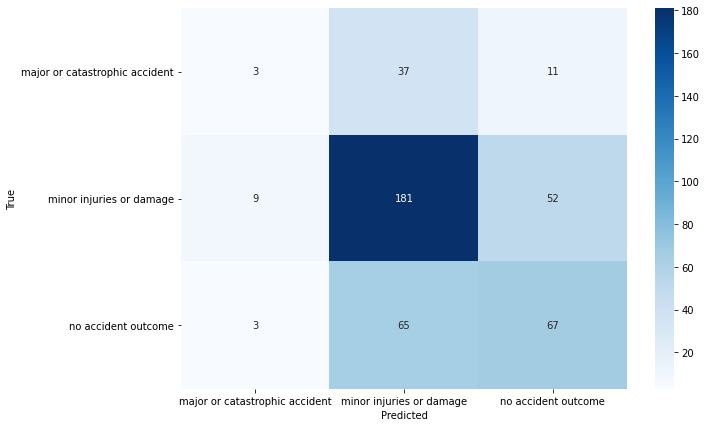

In [68]:
test_mat = confusion_matrix(test_true, test_predicted)

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(test_mat, annot=True, fmt='d',
            xticklabels=category_names, yticklabels=category_names, cmap="Blues")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

Here is also the performance metrics of the model:

In [72]:
print("TEST DATA: \n", metrics.classification_report(test_true, test_predicted, target_names=category_names, zero_division=1))

TEST DATA: 
                                 precision    recall  f1-score   support

major or catastrophic accident       0.20      0.06      0.09        51
      minor injuries or damage       0.64      0.75      0.69       242
           no accident outcome       0.52      0.50      0.51       135

                      accuracy                           0.59       428
                     macro avg       0.45      0.43      0.43       428
                  weighted avg       0.55      0.59      0.56       428



This model definitely has better performance than Random Forest classifier, but still this percentage of accuracy should not be satisfying. For me, the next step in aviation classification would be training model on larger sets and maybe pretraining tokenizer specially for aviation reports.